- https://www.nature.com/articles/nbt.2657 network cleanup
- https://www.nature.com/articles/nbt.2601 silencing
- https://www.nature.com/articles/nbt.2635 network deconvolution

In [29]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

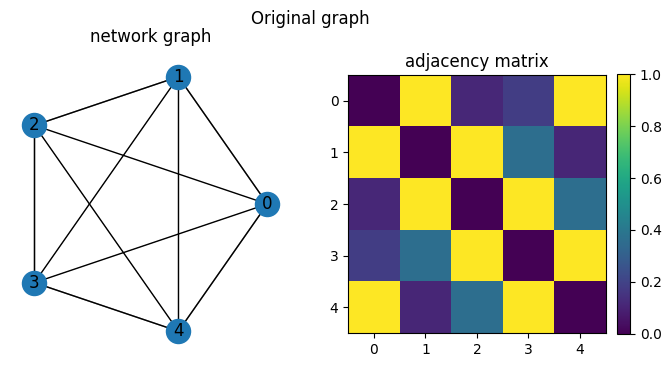

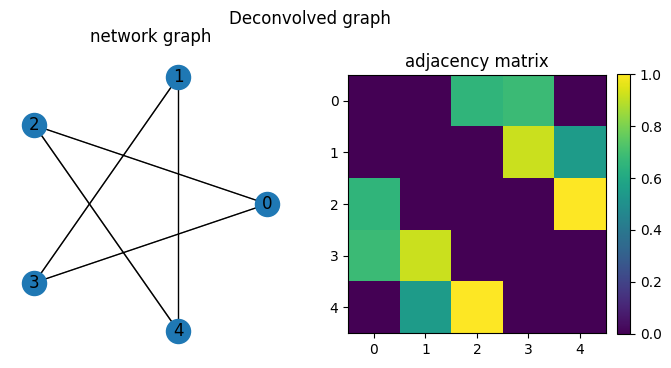

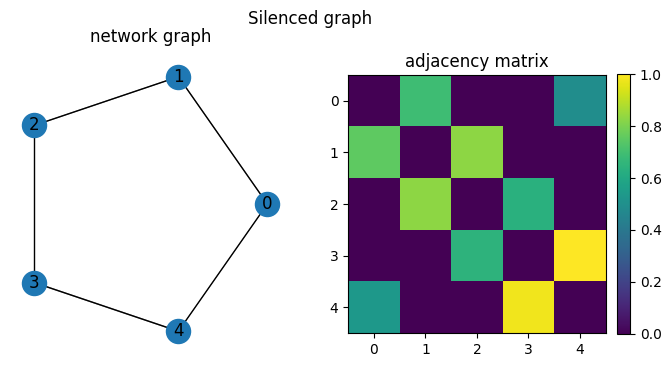

In [85]:
# create a graph with 5 elements that are connected in a semi-ring with weight 1, starting at 0
def generate_clique(n_nodes, indirect=[2, 3]):
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_edges_from([(i, (i + 1) % n_nodes, {"weight": 1}) for i in range(n_nodes)])

    # connect to indirect neighbors
    for i in range(n_nodes):
        for j in indirect:
            # check if edge already exists
            if G.has_edge(i, (i + j) % n_nodes):
                continue
            G.add_edge(i, (i + j) % n_nodes, weight=1 / j * np.random.uniform())
    return G


# draw the graph using circle layout, with edge weights as transparency
def draw_with_weights(G, ax=None):
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, ax=ax)
    widths = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=widths.keys(),
        width=[w for w in widths.values()],
        alpha=0.5,
        ax=ax,
    )


def draw_matrix(A, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    # convert to graph
    G = nx.from_numpy_matrix(A)
    ax1.set_title("network graph")
    draw_with_weights(G, ax=ax1)
    ax2.set_title("adjacency matrix")
    # imshow of the adjacency matrix with colorbar
    im = ax2.imshow(A, cmap="viridis")
    fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    plt.show()


def network_deconvolution(G):
    """Deconvolve a network matrix using the eigen decomposition.
    https://www.nature.com/articles/nbt.2635
    """
    # eigen decomposition
    lam, v = scipy.linalg.eigh(G)
    # rescale the eigenvalues
    # also add small value to avoid division by zero
    lam_dir = lam / (1 + lam)
    # reconstruct the deconvolved matrix
    G_dir = v @ np.diag(lam_dir) @ v.T

    # remove diagonal, threshold positive values, and rescale in-place
    np.fill_diagonal(G_dir, 0)
    np.maximum(G_dir, 0, out=G_dir)
    G_dir /= np.max(G_dir)

    # NOTE: check reconstruction
    # G_dir = v @ np.diag(lam) @ v.T
    return G_dir


def network_silencing(G):
    """Remove indirect effects using a silencing method.
    https://www.nature.com/articles/nbt.2601
    """
    # svd of G
    u, s, vh = scipy.linalg.svd(G)

    peturb = np.diag((G - np.eye(G.shape[0])) @ G)
    G_dir = (
        (G - np.eye(G.shape[0]) + np.diag(peturb))
        # multiply with pseudo inverse
        @ (u @ np.linalg.pinv(np.diag(s)) @ vh)
    )

    # remove diagonal, threshold positive values, and rescale in-place
    np.fill_diagonal(G_dir, 0)
    np.maximum(G_dir, 0, out=G_dir)
    G_dir /= np.max(G_dir)

    # NOTE: check reconstruction
    # G_dir = u @ np.diag(s) @ vh
    return G_dir


G = generate_clique(5)
A = nx.to_numpy_matrix(G)
draw_matrix(A, "Original graph")

A_deconv = network_deconvolution(A)
draw_matrix(A_deconv, "Deconvolved graph")

A_silenced = network_silencing(A)
draw_matrix(A_silenced, "Silenced graph")

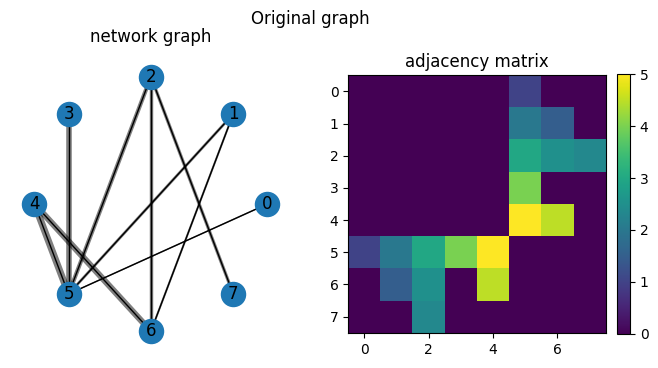

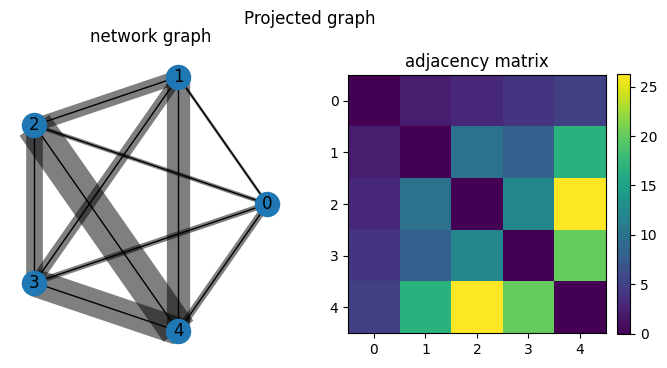

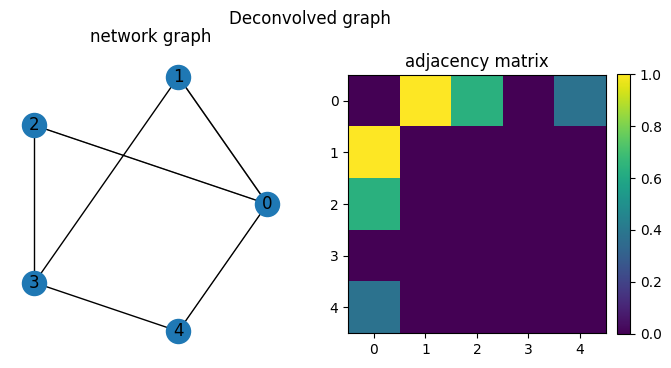

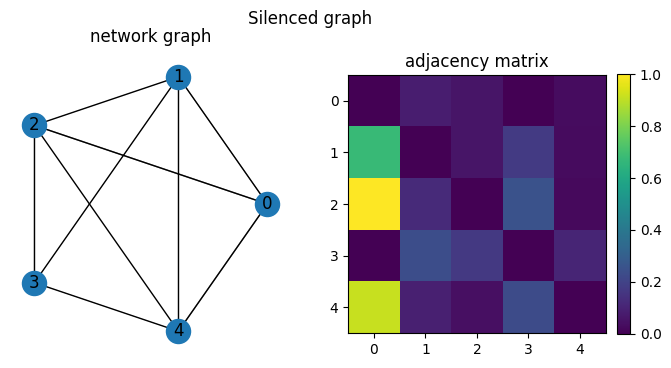

In [83]:
# now lets generate a bipartite graph that's that simulates the tag network, and see the effects here


def generate_bipartite(n_nodes, n_tags):
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    G.add_nodes_from(range(n_nodes, n_nodes + n_tags))
    for i in range(n_nodes):
        k = i % n_tags + 1
        # connect to k tags
        for j in range(k):
            G.add_edge(i, n_nodes + j, weight=i + 1 / (j + 1))
    return G


n, k = 5, 3
G = generate_bipartite(n, k)
A = nx.to_numpy_matrix(G)
draw_matrix(A, "Original graph")

P = (A.T @ A)[:n, :n]
np.fill_diagonal(P, 0)
draw_matrix(P, "Projected graph")

# deconvolve
draw_matrix(network_deconvolution(P), "Deconvolved graph")

# silence
draw_matrix(network_silencing(P), "Silenced graph")